In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

# Set device 
device = "cuda:1"

### 1. Diffusion Scheduler ###
# ----------------------------
# Manages the noise schedule and the forward (noising) process.

def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    """
    Creates a linear schedule for beta, the noise variance.
    """
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    """
    vals:    a 1-D tensor of length T (e.g. betas, alphas, or any T-long schedule).
    t:       a LongTensor of shape [B] with timestep indices (each in 0…T-1).
    x_shape: the shape of the noised image batch, e.g. [B, C, H, W].
    """
    batch_size = t.shape[0]              # B

    # 1) Gather the t-th element from `vals` for each batch entry.
    #    vals.gather(-1, t_cpu) returns shape [B]
    out = vals.gather(-1, t.cpu())

    # 2) Reshape [B] → [B, 1, 1, 1, …] so it can multiply an image tensor of shape x_shape.
    #    We keep B, then insert (len(x_shape)-1) singleton dims:
    #      e.g. if x_shape=[B,C,H,W] → reshape to [B,1,1,1]
    out = out.reshape(batch_size, *((1,) * (len(x_shape) - 1)))

    # 3) Move back to the original device (GPU/CPU) if needed:
    return out.to(t.device)

# --- Forward Process (q) ---
def forward_diffusion_sample(x_0, t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod):
    """
    Takes a clean image and a timestep and returns a noisy version of the image.
    This is based on the closed-form formula: x_t = sqrt(alpha_bar_t) * x_0 + sqrt(1 - alpha_bar_t) * N(0, I)
    It also returns the noise that was added, which will be the target for our model.
    """
    # Sample random noise from a standard normal distribution
    noise = torch.randn_like(x_0)

    # Get the sqrt(alpha_bar_t) value for the given timestep t
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    
    # Get the sqrt(1 - alpha_bar_t) value
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )

    # Compute the noisy image x_t
    mean = sqrt_alphas_cumprod_t * x_0
    variance = sqrt_one_minus_alphas_cumprod_t * noise
    
    # Return the noisy image and the noise that was added
    return mean + variance, noise

/raid/home/chandanj/miniconda3/envs/raghava/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
### 2. U-Net Model Architecture ###
# ---------------------------------
# The U-Net's job is to take a noisy image and a timestep embedding
# and predict the noise that was added to the original image.


class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()

        # A tiny MLP that maps the time embedding into a per-channel bias
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)

        if up:
            # If this block is an “upsampling” block:
            #   - conv1 takes concatenated features (from skip-connection)
            self.conv1     = nn.Conv2d(2*in_ch, out_ch, kernel_size=3, padding=1)
            #   - transform upsamples spatially by factor 2
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, kernel_size=4, stride=2, padding=1)
        else:
            # If this block is a “downsampling” block:
            #   - conv1 takes normal in_ch → out_ch
            self.conv1     = nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1)
            #   - transform downsamples spatially by factor 2
            self.transform = nn.Conv2d(out_ch, out_ch, kernel_size=4, stride=2, padding=1)

        # A second 3×3 conv to refine features after adding time
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1)

        # BatchNorm + ReLU after each conv for stable training
        self.bn1   = nn.BatchNorm2d(out_ch)
        self.bn2   = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()

    def forward(self, x, t):
        # 1) First conv → BN → ReLU
        h = self.conv1(x)
        h = self.bn1(h)
        h = self.relu(h)

        # 2) Compute a channel-wise bias from the timestep embedding
        #    t is shape [B, time_emb_dim]; after MLP: [B, out_ch]
        time_emb = self.time_mlp(t)
        time_emb = self.relu(time_emb)

        # 3) Reshape time_emb to [B, out_ch, 1, 1] so we can add it per-channel
        time_emb = time_emb[..., None, None]

        # 4) Add the time bias to every spatial location
        h = h + time_emb

        # 5) Second conv → BN → ReLU
        h = self.conv2(h)
        h = self.bn2(h)
        h = self.relu(h)

        # 6) Finally, either upsample or downsample by 2×
        return self.transform(h)
    
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        # dim: the total size of the output embedding (must be even)
        self.dim = dim

    def forward(self, time):
        """
        time: a 1D tensor of shape [batch_size] containing scalar timestep indices.
        returns: a tensor of shape [batch_size, dim] with sinusoidal embeddings.
        """
        # 1) Figure out which device (CPU/GPU) to put our tensors on
        device = time.device

        # 2) We split the embedding dimension in half: one half for sin(), one half for cos()
        half_dim = self.dim // 2

        # 3) Compute the frequency “scale” term:
        #    log(10000) / (half_dim - 1) sets the base for the geometric progression of frequencies
        freq_scale = math.log(10000) / (half_dim - 1)

        # 4) Create a tensor of shape [half_dim] containing [0, 1, 2, …, half_dim-1]
        #    multiplied by -freq_scale, so that exp(...) gives us frequencies that
        #    increase geometrically from 1 to 1/10000.
        inv_freq = torch.exp(torch.arange(half_dim, device=device) * -freq_scale)

        # 5) Outer‐product: for each batch index t we multiply by each inverse frequency
        #    Resulting shape: [batch_size, half_dim]
        sinusoid_input = time[:, None] * inv_freq[None, :]

        # 6) Apply sin to the first half, cos to the second half, and concatenate:
        #    gives a [batch_size, half_dim*2 = dim] embedding
        emb = torch.cat([sinusoid_input.sin(), sinusoid_input.cos()], dim=-1)

        return emb

In [3]:
class SimpleUnet(nn.Module):
    def __init__(self):
        super().__init__()
        image_channels = 1
        down_channels = (64, 128, 256)
        up_channels = (256, 128, 64)
        out_dim = 1 
        time_emb_dim = 32

        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], time_emb_dim) for i in range(len(down_channels)-1)])
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], time_emb_dim, up=True) for i in range(len(up_channels)-1)])
        # The output of the model is the predicted noise, which has the same dimensions as the input image.
        self.output = nn.Conv2d(up_channels[-1], image_channels, 1)

    def forward(self, x, timestep):
        t = self.time_mlp(timestep)
        x = self.conv0(x)
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            x = torch.cat((x, residual_x), dim=1)           
            x = up(x, t)
        return self.output(x)


In [4]:
### 3. Training ###
# -----------------

# Hyperparameters
IMG_SIZE = 32
BATCH_SIZE = 128
EPOCHS = 25
LR = 0.001
TIMESTEPS = 600

# --- Prepare Diffusion Schedule Constants ---
betas = linear_beta_schedule(timesteps=TIMESTEPS)
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)

# Constants needed for the forward process
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

# Constants needed for the reverse process (sampling)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

# --- Load Data ---
transforms_mnist = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]) # Normalize to [-1, 1]
])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms_mnist)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

# --- Initialize Model, Optimizer, Loss ---
model = SimpleUnet().to(device)
optimizer = optim.Adam(model.parameters(), lr=LR)
# The loss is the Mean Squared Error between the true noise and the predicted noise.
criterion = nn.MSELoss()
loss_history = []


Training started (Noise Estimation Method)...


Epoch 1/25: 100%|██████████| 468/468 [00:37<00:00, 12.36it/s]


Epoch 1 Average Loss: 0.0635


Epoch 2/25: 100%|██████████| 468/468 [00:37<00:00, 12.63it/s]


Epoch 2 Average Loss: 0.0330


Epoch 3/25: 100%|██████████| 468/468 [00:36<00:00, 12.86it/s]


Epoch 3 Average Loss: 0.0293


Epoch 4/25: 100%|██████████| 468/468 [00:36<00:00, 12.83it/s]


Epoch 4 Average Loss: 0.0281


Epoch 5/25: 100%|██████████| 468/468 [00:36<00:00, 12.81it/s]


Epoch 5 Average Loss: 0.0269


Epoch 6/25: 100%|██████████| 468/468 [00:37<00:00, 12.57it/s]


Epoch 6 Average Loss: 0.0262


Epoch 7/25: 100%|██████████| 468/468 [00:37<00:00, 12.53it/s]


Epoch 7 Average Loss: 0.0256


Epoch 8/25: 100%|██████████| 468/468 [00:36<00:00, 12.67it/s]


Epoch 8 Average Loss: 0.0251


Epoch 9/25: 100%|██████████| 468/468 [00:38<00:00, 12.07it/s]


Epoch 9 Average Loss: 0.0246


Epoch 10/25: 100%|██████████| 468/468 [00:37<00:00, 12.58it/s]


Epoch 10 Average Loss: 0.0247


Epoch 11/25: 100%|██████████| 468/468 [00:37<00:00, 12.43it/s]


Epoch 11 Average Loss: 0.0243


Epoch 12/25: 100%|██████████| 468/468 [00:38<00:00, 12.12it/s]


Epoch 12 Average Loss: 0.0239


Epoch 13/25: 100%|██████████| 468/468 [00:37<00:00, 12.53it/s]


Epoch 13 Average Loss: 0.0238


Epoch 14/25: 100%|██████████| 468/468 [00:36<00:00, 12.78it/s]


Epoch 14 Average Loss: 0.0233


Epoch 15/25: 100%|██████████| 468/468 [00:37<00:00, 12.57it/s]


Epoch 15 Average Loss: 0.0237


Epoch 16/25: 100%|██████████| 468/468 [00:37<00:00, 12.54it/s]


Epoch 16 Average Loss: 0.0231


Epoch 17/25: 100%|██████████| 468/468 [00:36<00:00, 12.72it/s]


Epoch 17 Average Loss: 0.0231


Epoch 18/25: 100%|██████████| 468/468 [00:36<00:00, 12.73it/s]


Epoch 18 Average Loss: 0.0231


Epoch 19/25: 100%|██████████| 468/468 [00:36<00:00, 12.87it/s]


Epoch 19 Average Loss: 0.0230


Epoch 20/25: 100%|██████████| 468/468 [00:36<00:00, 12.87it/s]


Epoch 20 Average Loss: 0.0227


Epoch 21/25: 100%|██████████| 468/468 [00:36<00:00, 12.75it/s]


Epoch 21 Average Loss: 0.0227


Epoch 22/25: 100%|██████████| 468/468 [00:36<00:00, 12.78it/s]


Epoch 22 Average Loss: 0.0225


Epoch 23/25: 100%|██████████| 468/468 [00:37<00:00, 12.53it/s]


Epoch 23 Average Loss: 0.0224


Epoch 24/25: 100%|██████████| 468/468 [00:37<00:00, 12.52it/s]


Epoch 24 Average Loss: 0.0222


Epoch 25/25: 100%|██████████| 468/468 [00:38<00:00, 12.10it/s]


Epoch 25 Average Loss: 0.0225
Training finished.


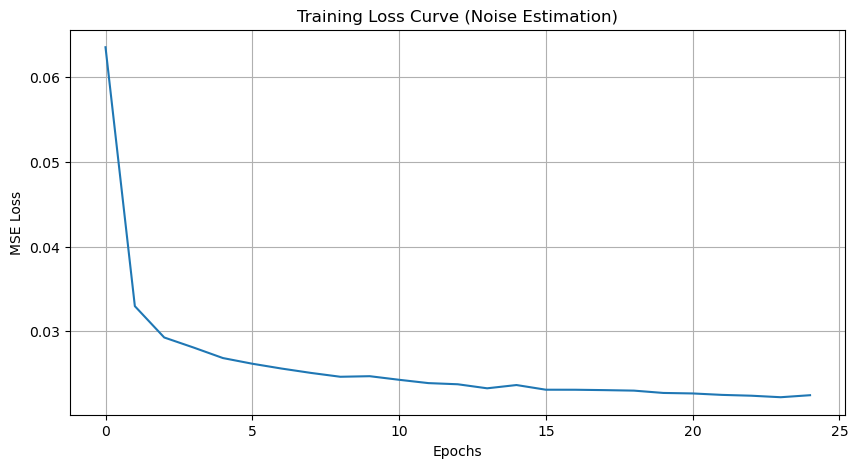

In [5]:
# --- Training Loop ---
print("Training started (Noise Estimation Method)...")
for epoch in range(EPOCHS):
    epoch_loss = 0.0
    for step, (images, _) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")):
        optimizer.zero_grad()

        # 1. Get a batch of clean images x0 and move to device
        x0 = images.to(device)

        # 2. Sample a random timestep t for each image
        t = torch.randint(0, TIMESTEPS, (BATCH_SIZE,), device=device).long()
        
        # 3. Create noisy images x_t and get the added noise (our target)
        xt, noise_target = forward_diffusion_sample(x0, t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod)

        # 4. Predict the noise using the U-Net model
        predicted_noise = model(xt, t)

        # 5. Calculate the loss between the model's prediction and the actual noise
        loss = criterion(noise_target, predicted_noise)
        
        # 6. Backpropagate and update weights
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        
    avg_epoch_loss = epoch_loss / len(train_loader)
    loss_history.append(avg_epoch_loss)
    print(f"Epoch {epoch+1} Average Loss: {avg_epoch_loss:.4f}")

print("Training finished.")

# --- Plot Loss Curve ---
plt.figure(figsize=(10, 5))
plt.plot(loss_history)
plt.title("Training Loss Curve (Noise Estimation)")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.show()


Generating images...


Sampling: 100%|██████████| 600/600 [00:02<00:00, 280.59it/s]


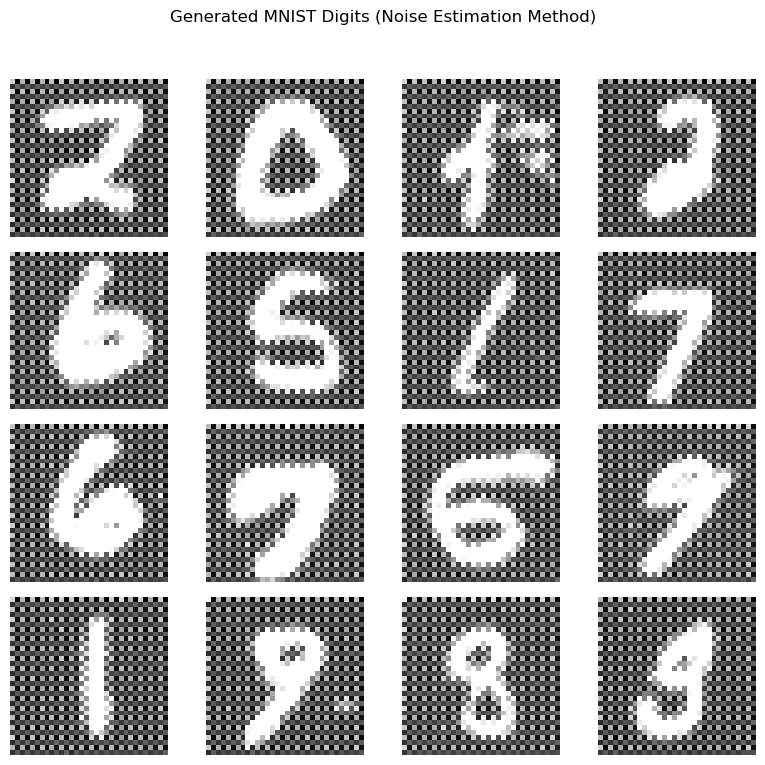

In [6]:
### 4. Image Generation (Sampling) ###
# ------------------------------------
# To generate an image, we perform the reverse diffusion process.
# We start with pure noise and denoise it over T timesteps using the trained model.

@torch.no_grad()
def sample_timestep(x, t):
    """
    Core sampling function for a single timestep.
    It predicts the noise and uses it to calculate the image for the previous timestep.
    Formula: x_{t-1} = 1/sqrt(alpha_t) * (x_t - (beta_t/sqrt(1-alpha_bar_t)) * pred_noise) + sqrt(beta_t) * Z
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)
    
    # Use the U-Net to predict the noise from the current image x_t
    predicted_noise = model(x, t)
    
    # Calculate the mean of the reverse distribution using the predicted noise
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * predicted_noise / sqrt_one_minus_alphas_cumprod_t
    )
    
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)
    
    if t.all().item() == 0:
        # For the last step (t=0), there's no noise added
        return model_mean
    else:
        # Add noise to the mean to get the image for the previous step
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise

@torch.no_grad()
def generate_images(num_images=16):
    """
    Generates new images by running the full reverse diffusion process.
    """
    print("Generating images...")
    # Start with pure random noise (x_T)
    img = torch.randn((num_images, 1, IMG_SIZE, IMG_SIZE), device=device)
    
    # Loop backwards through the timesteps
    for i in tqdm(reversed(range(0, TIMESTEPS)), desc="Sampling", total=TIMESTEPS):
        t = torch.full((num_images,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
    
    # Un-normalize images from [-1, 1] to [0, 1]
    img = (img + 1) * 0.5
    img = img.clamp(0, 1)
    return img

# --- Generate and Plot Images ---
generated_images = generate_images(num_images=16)

plt.figure(figsize=(8, 8))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(generated_images[i].cpu().squeeze(), cmap='gray')
    plt.axis('off')
plt.suptitle("Generated MNIST Digits (Noise Estimation Method)")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()